Korenaga 2011
======

Temperature dependent convection
----

This Notebooks implements the case of two-dimensional, incompressible, internally-heated fmantle convection.


**Keywords:** Stokes system, advective diffusive systems, analysis tools, tools for post analysis, rheologies


**References**

Korenaga, Jun. "Scaling of plate tectonic convection with pseudoplastic rheology." Journal of Geophysical Research: Solid Earth 115.B11 (2010).
http://onlinelibrary.wiley.com/doi/10.1029/2010JB007670/full

In [204]:
import numpy as np
import underworld as uw
import math
from underworld import function as fn
import glucifer

import os
import sys
import natsort
import shutil
from easydict import EasyDict as edict
import slippy2 as sp
import operator
import pint
import time
import operator

from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

Model name and directories
-----

In [205]:
############
#Model name.  
############
Model = "T"
ModNum = 0

if len(sys.argv) == 1:
    ModIt = "Base"
elif sys.argv[1] == '-f':
    ModIt = "Base"
else:
    ModIt = str(sys.argv[1])

In [206]:
###########
#Standard output directory setup
###########


outputPath = "results" + "/" +  str(Model) + "/" + str(ModNum) + "/" + str(ModIt) + "/"
imagePath = outputPath + 'images/'
filePath = outputPath + 'files/'
checkpointPath = outputPath + 'checkpoint/'
dbPath = outputPath + 'gldbs/'
outputFile = 'results_model' + Model + '_' + str(ModNum) + '_' + str(ModIt) + '.dat'

if uw.rank()==0:
    # make directories if they don't exist
    if not os.path.isdir(outputPath):
        os.makedirs(outputPath)
    if not os.path.isdir(checkpointPath):
        os.makedirs(checkpointPath)
    if not os.path.isdir(imagePath):
        os.makedirs(imagePath)
    if not os.path.isdir(dbPath):
        os.makedirs(dbPath)
    if not os.path.isdir(filePath):
        os.makedirs(filePath)
        
comm.Barrier() #Barrier here so no procs run the check in the next cell too early

In [207]:
###########
#Check if starting from checkpoint
###########

checkdirs = []
for dirpath, dirnames, files in os.walk(checkpointPath):
    if files:
        print dirpath, 'has files'
        checkpointLoad = True
        checkdirs.append(dirpath)
    if not files:
        print dirpath, 'is empty'
        checkpointLoad = False

results/T/0/Base/checkpoint/ is empty


Setup parameters
-----

Set simulation parameters for test.

**Use pint to setup any unit conversions we'll need**

In [208]:
u = pint.UnitRegistry()
cmpery = u.cm/u.year
mpermy = u.m/u.megayear

cmpery.to(mpermy)

<Quantity(10000.0, 'meter / megayear')>

**Set parameter dictionaries**

In [209]:
#dimensional parameter dictionary
dp = edict({'LS':2900.*1e3,
           'rho':4000,
           'g':9.8, 
           'eta0':1e19, #I think...page 14
           'k':10**-6,
           'a':2e-5, 
           'deltaT':1300,
           'TS':273.,
           'TB':1573.,
           'cohesion':20e6,
           'fc':0.02,
           'E':300000.,
           'R':8.314}) 


#scale_factors

sf = edict({'stress':dp.LS**2/(dp.k*dp.eta0),
            'lith_grad':dp.rho*dp.g*(dp.LS)**3/(dp.eta0*dp.k) ,
            'vel':dp.LS/dp.k,
            'SR':dp.LS**2/dp.k,
            'W':(dp.rho*dp.g*dp.LS)/(dp.R*dp.deltaT), #This is the activation energy scale, in terms of depth (not pressure)
            'E': 1./(dp.R*dp.deltaT)})

#dimensionless parameters

ndp = edict({'RA':(dp.g*dp.rho*dp.a*dp.deltaT *(dp.LS)**3)/(dp.k*dp.eta0),
            'cohesion':dp.cohesion*sf.stress,
            'fcd':dp.fc*sf.lith_grad,
            'gamma':dp.fc/(dp.a*dp.deltaT),
            'TS':0.,
            'TB':1.,
            'eta_min':1e-3,
            'StAeta0':0.01,
            'eta_max':1e5,
            'H':20.})


In [210]:
ndp.RA  = 1e6
#eta0 = 1.0e3

**Model setup parameters**

In [211]:
###########
#Model setup parameters
###########

refineMesh = True
stickyAir = False 



MINX = -2.
MINY = 0.
MAXX = 2.

#MAXY = 1.035
MAXY = 1.

if MINX == 0.:
    squareModel = True
else: 
    squareModel = False
    
    
dim = 2          # number of spatial dimensions


#MESH STUFF

RES = 48


Xres = int(RES*4)


if stickyAir:
    Yres = RES
    MAXY = 1. + dp.StALS/dp.LS #150km
    
else:
    Yres = RES
    MAXY = 1.


periodic = [True, False]
elementType = "Q1/dQ0"
#elementType ="Q2/DPC1"


#System/Solver stuff

PIC_integration=True
ppc = 25

#Output and safety stuff

swarm_repop = 5
files_output = 1
gldbs_output = 20
checkpoint_every = 2
metric_output = 10

Create mesh and finite element variables
------

In [212]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"),
                                 elementRes  = (Xres, Yres), 
                                 minCoord    = (MINX, MINY), 
                                 maxCoord    = (MAXX, MAXY))
velocityField       = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2 )
pressureField       = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )
temperatureField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )
temperatureDotField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )

Initial conditions
-------


**Plot initial temperature**

In [213]:
coordinate = fn.input()
depthFn = 1. - coordinate[1]

In [214]:
if not checkpointLoad:
    # Setup temperature initial condition via numpy arrays
    A = 0.2
    #Note that width = height = 1
    pertCoeff = depthFn + A*(fn.math.cos( math.pi * coordinate[0])  * fn.math.sin( math.pi * coordinate[1] ))        
    temperatureField.data[:] = pertCoeff.evaluate(mesh)  

In [215]:
figtemp = glucifer.Figure()
figtemp.append( glucifer.objects.Surface(mesh, temperatureField) )
#figtemp.show()

**Boundary conditions**

In [216]:
for index in mesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = ndp.TB
for index in mesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = ndp.TS
    
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
tWalls = mesh.specialSets["MaxJ_VertexSet"]
bWalls =mesh.specialSets["MinJ_VertexSet"]


freeslipBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               indexSetsPerDof = ( iWalls, jWalls) )
# also set dirichlet for temp field
dirichTempBC = uw.conditions.DirichletCondition(     variable=temperatureField, 
                                              indexSetsPerDof=(tWalls,) )
dT_dy = [0.,0.]

# also set dirichlet for temp field
neumannTempBC = uw.conditions.NeumannCondition( dT_dy, variable=temperatureField, 
                                         indexSetsPerDof=bWalls)



Particles
-----


In [238]:
###########
#Material Swarm and variables
###########

gSwarm = uw.swarm.Swarm(mesh=mesh, particleEscape=True)
tracerVariable = gSwarm.add_variable( dataType="int", count=1)
layout = uw.swarm.layouts.PerCellRandomLayout(swarm=gSwarm, particlesPerCell=15)
# Now use it to populate.
gSwarm.populate_using_layout( layout=layout )
tracerVariable.data[:] = 1

In [218]:
square_size = 0.1

xlist = np.arange(mesh.minCoord[0] + square_size/2., mesh.maxCoord[0] + square_size/2., square_size)
xlist = zip(xlist[:], xlist[1:])[::2]
ylist = np.arange(mesh.minCoord[1] + square_size/2., mesh.maxCoord[1] + square_size/2., square_size)
ylist = zip(ylist[:], ylist[1:])[::2]
xops = []
for vals in xlist:
    xops.append( (operator.and_(   operator.gt(coordinate[0],vals[0]),   operator.lt(coordinate[0],vals[1])  ),0.) )
xops.append((True,1.))

testfunc = fn.branching.conditional(xops) 

yops = []
for vals in ylist:
    yops.append( (operator.and_(   operator.gt(coordinate[1],vals[0]),   operator.lt(coordinate[1],vals[1])  ),0.) )
yops.append((True,testfunc))

testfunc2 = fn.branching.conditional(yops) 

In [219]:
tracerVariable.data[:] = testfunc.evaluate(gSwarm)
tracerVariable.data[:] = testfunc2.evaluate(gSwarm)

In [220]:
#Pack some stuff into a database as well
fig= glucifer.Figure()
fig.append( glucifer.objects.Points(gSwarm,tracerVariable, colours= 'white black'))
#fig.append( glucifer.objects.Surface(mesh, dummyField))
#fig.show()

Set up material parameters and functions
-----

Setup the viscosity to be a function of the temperature. Recall that these functions and values are preserved for the entire simulation time. 

In [221]:
# The yeilding of the upper slab is dependent on the strain rate.
strainRate_2ndInvariant = fn.tensor.second_invariant( 
                            fn.tensor.symmetric( 
                            velocityField.fn_gradient ))


theta = (dp.E *dp.deltaT)/(dp.R*(dp.TS + dp.deltaT)**2)
print(theta )

18.9582017921


In [222]:
############
#Rheology
#############
#
#The final mantle rheology is composed as follows*:
# 
#
# mantleviscosityFn = max{  min{(1/eta_arr + 1/eta_p)**-1,
#                           eta_max},
#                         eta_min}
#                      
#eta_arr => arhennius viscosity (could be linear or non linear)
#eta_p   => stress-limiting effective viscosity
#



eta_arr = fn.math.exp(theta*(1. - temperatureField))
ys =  ndp.cohesion + (depthFn*ndp.fcd)#Stress-limiting effective viscosity
eta_p = ys/(strainRate_2ndInvariant/math.sqrt(0.5)) #extra factor to account for underworld second invariant form


mantleviscosityFn = fn.misc.max(fn.misc.min(1./(((1./eta_arr) + (1./eta_p))), ndp.eta_max), ndp.eta_min)

**Plot the initial viscosity**

Plot the viscosity, which is a function of temperature, using the initial temperature conditions set above.

In [223]:
figEta = glucifer.Figure()
figEta.append( glucifer.objects.Surface(mesh, mantleviscosityFn) )
#figEta.show()

System setup
-----

Since we are using a previously constructed temperature field, we will use a single Stokes solve to get consistent velocity and pressure fields.

**Setup a Stokes system**

In [224]:
gravity = np.array([ 0.0, 1.0 ])
buoyancyFn = list(gravity*ndp.RA)

In [225]:
stokesPIC = uw.systems.Stokes(velocityField=velocityField, 
                              pressureField=pressureField,
                              conditions=[freeslipBC,],
                              fn_viscosity=eta_arr, 
                              fn_bodyforce=buoyancyFn )

**Set up and solve the Stokes system**

In [226]:
solver = uw.systems.Solver(stokesPIC)
solver.solve()

**Add the non-linear viscosity to the Stokes system**


In [227]:
stokesPIC.fn_viscosity = mantleviscosityFn

In [228]:
solver.set_inner_method("superludist")
solver.options.scr.ksp_type="cg"
solver.set_penalty(1.0e7)
solver.options.scr.ksp_rtol = 1.0e-4
solver.solve(nonLinearIterate=True)
solver.print_stats()


 
Pressure iterations:   3
Velocity iterations:   1 (presolve)      
Velocity iterations:  -1 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:   1 (total solve)   
 
SCR RHS  solve time: 1.9560e-01
Pressure solve time: 2.3417e-02
Velocity solve time: 8.7696e-02 (backsolve)
Total solve time   : 3.4491e-01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 



**Create an advective diffusive system**

In [229]:
advDiff = uw.systems.AdvectionDiffusion( phiField       = temperatureField, 
                                         phiDotField    = temperatureDotField, 
                                         velocityField  = velocityField,
                                         fn_sourceTerm    = 20.0,
                                         fn_diffusivity = 1.0, 
                                         conditions     = [neumannTempBC, dirichTempBC] )

passiveadvector = uw.systems.SwarmAdvector( swarm         = gSwarm, 
                                     velocityField = velocityField, 
                                     order         = 1)

In [230]:
population_control = uw.swarm.PopulationControl(gSwarm,deleteThreshold=0.2,splitThreshold=1.,maxDeletions=3,maxSplits=0, aggressive=True, particlesPerCell=15)

Analysis tools
-----

In [231]:
tempint = uw.utils.Integral( temperatureField, mesh )
areaint = uw.utils.Integral( 1.,               mesh )

v2int   = uw.utils.Integral( fn.math.dot(velocityField,velocityField), mesh )

dwint   = uw.utils.Integral( temperatureField*velocityField[1], mesh )

sinner = fn.math.dot( strainRate_2ndInvariant, strainRate_2ndInvariant )
vdint = uw.utils.Integral( (4.*mantleviscosityFn*sinner), mesh )

In [232]:
rmsSurfInt = uw.utils.Integral( fn=velocityField[0]*velocityField[0], mesh=mesh, integrationType='Surface', 
                          surfaceIndexSet=mesh.specialSets["MaxJ_VertexSet"])
nuTop      = uw.utils.Integral( fn=temperatureField.fn_gradient[1],    mesh=mesh, integrationType='Surface', 
                          surfaceIndexSet=mesh.specialSets["MaxJ_VertexSet"])
nuBottom   = uw.utils.Integral( fn=temperatureField.fn_gradient[1],    mesh=mesh, integrationType='Surface', 
                          surfaceIndexSet=mesh.specialSets["MinJ_VertexSet"])

In [233]:
def avg_temp():
    return tempint.evaluate()[0]/areaint.evaluate()[0]

def nusseltTB(temp_field, mesh):
    return -nuTop.evaluate()[0], -nuBottom.evaluate()[0]

def rms():
    return math.sqrt(v2int.evaluate()[0]/areaint.evaluate()[0])

def rms_surf():
    return math.sqrt(rmsSurfInt.evaluate()[0])

def max_vx_surf(velfield, mesh):
    vuvelxfn = fn.view.min_max(velfield[0])
    vuvelxfn.evaluate(mesh.specialSets["MaxJ_VertexSet"])
    return vuvelxfn.max_global()

def gravwork(workfn):
    return workfn.evaluate()[0]

def viscdis(vdissfn):
    return vdissfn.evaluate()[0]

def visc_extr(viscfn):
    vuviscfn = fn.view.min_max(viscfn)
    vuviscfn.evaluate(mesh)
    return vuviscfn.max_global(), vuviscfn.min_global()

In [234]:
v2sum_integral  = uw.utils.Integral( mesh=mesh, fn=fn.math.dot( velocityField, velocityField ) )
volume_integral = uw.utils.Integral( mesh=mesh, fn=1. )
Vrms = math.sqrt( v2sum_integral.evaluate()[0] )/volume_integral.evaluate()[0]



if(uw.rank()==0):
    print('Initial Vrms = {0:.3f}'.format(Vrms))

Initial Vrms = 0.034


In [235]:
# Calculate the Metrics, only on 1 of the processors:
Avg_temp = avg_temp()
Rms = rms()
Rms_surf = rms_surf()
Max_vx_surf = max_vx_surf(velocityField, mesh)
Gravwork = gravwork(dwint)
Viscdis = viscdis(vdint)
nu1, nu0 = nusseltTB(temperatureField, mesh) # return top then bottom
etamax, etamin = visc_extr(mantleviscosityFn)

In [236]:
if(uw.rank()==0):
    print('Initial RMS_surf = {0:.3f}'.format(Rms_surf))

Initial RMS_surf = 0.000


Viz.
-----

In [237]:
#tracerVariable.data


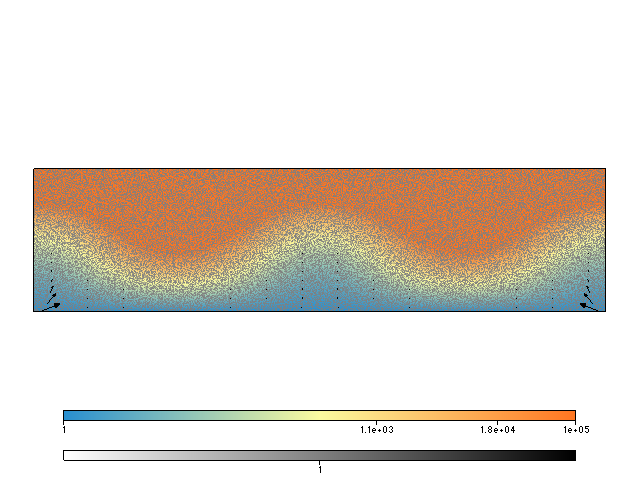

In [246]:
#Pack some stuff into a database as well
figDb = glucifer.Figure()
#figDb.append( glucifer.objects.Mesh(mesh))
figDb.append( glucifer.objects.VectorArrows(mesh,velocityField, scaling=0.005))
figDb.append( glucifer.objects.Points(gSwarm,tracerVariable, colours= 'white black'))
figDb.append( glucifer.objects.Surface(mesh, mantleviscosityFn, logScale=True))
#figDb.append( glucifer.objects.Surface(mesh, temperatureField))
figDb.show()

Main simulation loop
-----

Run a few advection and Stokes solver steps to make sure we are in, or close to, equilibrium.

In [26]:
temperatureField.data.min()

0.0

In [27]:

steps_end = 20

In [201]:
# initialise timer for computation
start = time.clock()
# setup summary output file (name above)
if checkpointLoad:
    if uw.rank() == 0:
        shutil.copyfile(os.path.join(checkpointLoadDir, outputFile), outputPath+outputFile)
    comm.Barrier()
    f_o = open(os.path.join(outputPath, outputFile), 'a')
    prevdata = np.genfromtxt(os.path.join(outputPath, outputFile), skip_header=0, skip_footer=0)
    if len(prevdata.shape) == 1: #this is in case there is only one line in previous file
        realtime = prevdata[0]
    else:
        realtime = prevdata[prevdata.shape[0]-1, 0]
    step = int(checkpointLoadDir.split('/')[-1])
    timevals = [0.]
else:
    f_o = open(outputPath+outputFile, 'w')
    realtime = 0.
    step = 0
    timevals = [0.]

In [202]:
#while step < steps_end:
while realtime < 1.:

    # solve Stokes and advection systems
    solver.solve(nonLinearIterate=True)
    dt = advDiff.get_max_dt()
    if step == 0:
        dt = 0.
    advDiff.integrate(dt)
    passiveadvector.integrate(dt)
    

    # Increment
    realtime += dt
    step += 1
    timevals.append(realtime)
    ################
    #Gldb output
    ################ 
    if (step % gldbs_output == 0):
        #Rebuild any necessary swarm variables
        #Write gldbs
        fnamedb = "dbFig" + "_" + str(ModIt) + "_" + str(step) + ".gldb"
        fullpath = os.path.join(outputPath + "gldbs/" + fnamedb)
        #figDb.show()
        figDb.save_database(fullpath)
    ################            
    # Calculate the Metrics, only on 1 of the processors:
    ################
    if (step % metric_output == 0):
        ###############
        #Swarm - based Metrics
        ###############
        # Calculate the RMS velocity and Nusselt number.
        # Calculate the Metrics, only on 1 of the processors:
        Avg_temp = avg_temp()
        Rms = rms()
        Rms_surf = rms_surf()
        Max_vx_surf = max_vx_surf(velocityField, mesh)
        Gravwork = gravwork(dwint)
        Viscdis = viscdis(vdint)
        nu1, nu0 = nusseltTB(temperatureField, mesh) # return top then bottom
        etamax, etamin = visc_extr(mantleviscosityFn)
        # output to summary text file
        if uw.rank()==0:
            f_o.write((11*'%-15s ' + '\n') % (realtime, Viscdis, float(nu0), float(nu1), Avg_temp, 
                                              Rms,Rms_surf,Max_vx_surf,Gravwork, etamax, etamin))
    ################
    #Also repopulate entire swarm periodically
    ################
    #if step % swarm_repop == 0:
    population_control.repopulate()
    
f_o.close()
print 'step =',step

NameError: name 'solver' is not defined

Comparison of benchmark values
-----



In [30]:
if(uw.rank()==0):
    print('Nu   = {0:.3f}'.format(Nu))
    print('Vrms = {0:.3f}'.format(Vrms))
    np.savetxt(outputPath+'summary.txt', [Nu, Vrms])

Nu   = 8.000
Vrms = 10.803



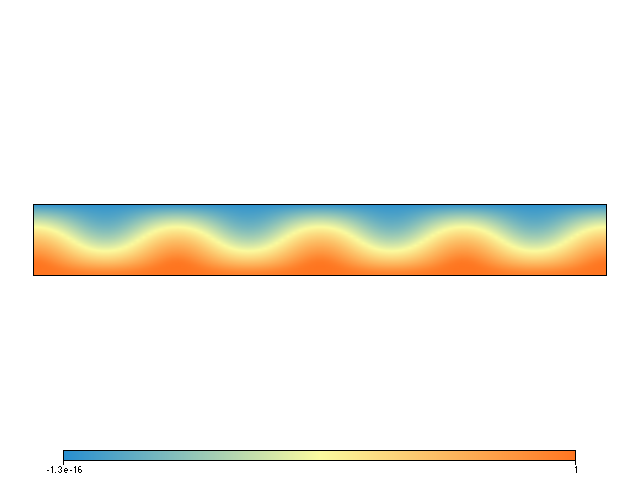

In [37]:

#figDb.show()


In [38]:
temperatureField.data.min()

0.0

In [39]:
ndp.TS

0.0

In [40]:
6./realtime

4319.583426730276

In [41]:
ndp.RA

2485726880.0

In [36]:
#temperatureField.evaluate(tWalls)